## 5. 고속 푸리에 변환 (Fast Fourier Transform, FFT)

### 5.1. 개요
  - 이산 푸리에 변환(영어: Discrete Fourier Transform, DFT)과 그 역변환을 빠르게 수행하는 알고리즘. 
  - FFT는 디지털 신호 처리에서 편미분 방정식의 근을 구하는 알고리즘에 이르기까지 많은 분야에서 사용.
    - 스펙트럼 분석기
    - OFDM 변복조기
    - CT 스캐너, MRI
    - MP3 압축방식
    - 영상 필터

1. 순차코드 
  - numpy library 이용
  - 2D FFT 수행

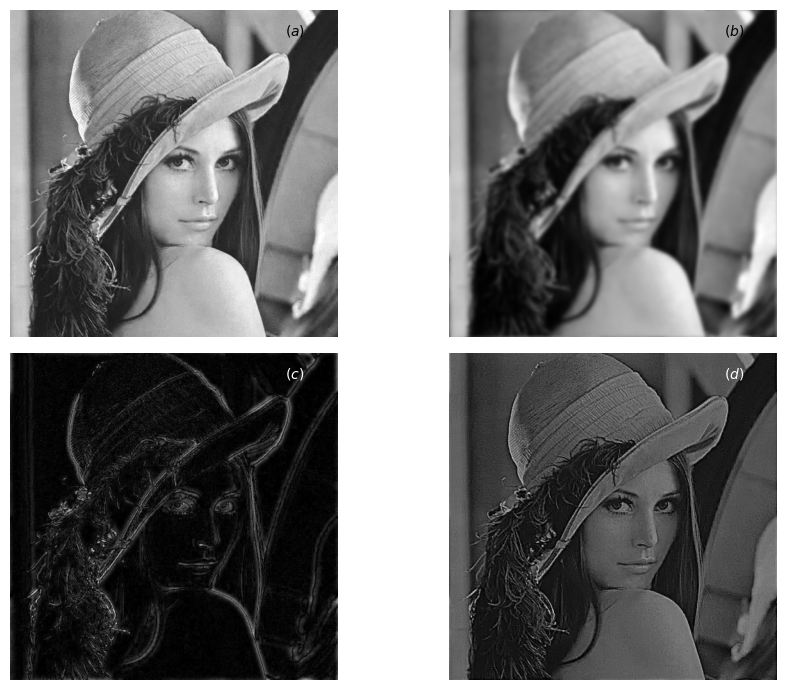

In [15]:
import matplotlib.pyplot as plt
import numpy as np

img = plt.imread('images/lenna.png')
imgr = img[:,:,0]
H = np.fft.fft2(imgr)
Hs = np.fft.fftshift(H)

ly, lx = imgr.shape

kY, kX = np.ogrid[-ly/2:ly/2, -lx/2:lx/2]

sig1, sigh, sigm = 30, 20, 50
Flow = np.exp( -(kX**2 + kY**2) / (2*sig1**2))
Fhgh = 1 - np.exp( -(kX**2 + kY**2) / (2*sigh**2))
Fmix = 1 - 0.7 * np.exp( -(kX**2 + kY**2) / (2*sigm**2))

Glow = Hs.copy() * Flow
Ghgh = Hs.copy() * Fhgh
Gmix = Hs.copy() * Fmix
iGlow = np.fft.ifftshift(Glow)
iGhgh = np.fft.ifftshift(Ghgh)
iGmix = np.fft.ifftshift(Gmix)
glow = np.fft.ifft2(iGlow)
ghgh = np.fft.ifft2(iGhgh)
gmix = np.fft.ifft2(iGmix)

fig = plt.figure(1, figsize = (10, 7))
plt.subplot(221)
plt.imshow(imgr, cmap = 'gray')
plt.axis('off')
plt.text(430,40,r'$(a)$', color = 'k')

plt.subplot(222)
plt.imshow(np.abs(glow), cmap = 'gray')
plt.axis('off')
plt.text(430,40,r'$(b)$', color = 'k')

ax = plt.subplot(223)
plt.imshow(np.abs(ghgh), cmap = 'gray')
plt.axis('off')
plt.text(430,40,r'$(c)$', color = 'w')

ax = plt.subplot(224)
plt.imshow(np.abs(gmix), cmap = 'gray')
plt.axis('off')
plt.text(430,40,r'$(d)$', color = 'w')

plt.tight_layout()
plt.show()



Text(40, 40, '$(b)$ Mixed filter')

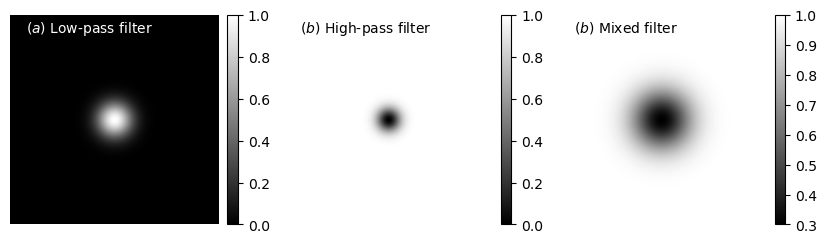

In [16]:
fig = plt.figure(2, figsize = (10, 7))
ax1 = plt.subplot(131)
pos = plt.imshow(Flow, cmap = 'gray')
plt.axis('off')
fig.colorbar(pos, ax=ax1, fraction=0.046, pad=0.04)
plt.text(40,40,r'$(a)$ Low-pass filter', color = 'w')

ax2 = plt.subplot(132)
pos = plt.imshow(Fhgh, cmap = 'gray')
plt.axis('off')
fig.colorbar(pos, ax=ax2, fraction=0.046, pad=0.04)
plt.text(40,40,r'$(b)$ High-pass filter', color = 'k')

ax3 = plt.subplot(133)
pos = plt.imshow(Fmix, cmap = 'gray')
plt.axis('off')
fig.colorbar(pos, ax=ax3, fraction=0.046, pad=0.04)
plt.text(40,40,r'$(b)$ Mixed filter', color = 'k')


2. High-pass 필터 순차코드

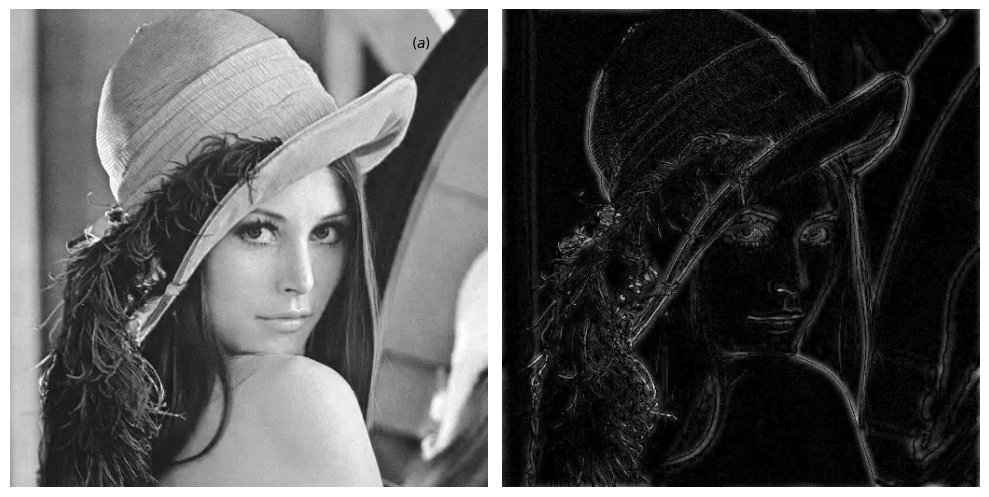

In [17]:
import matplotlib.pyplot as plt
import numpy as np

img = plt.imread('images/lenna.png')
imgr = img[:,:,0]
H = np.fft.fft2(imgr)
Hs = np.fft.fftshift(H)

ly, lx = imgr.shape

sigh = 20

kY, kX = np.ogrid[-ly/2:ly/2, -lx/2:lx/2]
Fhgh = 1 - np.exp( -(kX**2 + kY**2) / (2*sigh**2))

Ghgh = Hs.copy() * Fhgh
iGhgh = np.fft.ifftshift(Ghgh)
ghgh = np.fft.ifft2(iGhgh)

fig = plt.figure(1, figsize = (10, 7))
plt.subplot(121)
plt.imshow(imgr, cmap = 'gray')
plt.axis('off')
plt.text(430,40,r'$(a)$', color = 'k')

plt.subplot(122)
plt.imshow(np.abs(ghgh), cmap = 'gray')
plt.axis('off')
plt.text(430,40,r'$(b)$', color = 'k')

plt.tight_layout()
plt.show()

3. High-pass 필터 병렬화
  - 2D FFT를 x, y 방향 1D FFT로 수행
  - 각 방향별로 병렬화
  - FFT는 한 방향으로 모든 데이터가 필요
  - 방향에 따라 데이터를 분할
  
  <img src = "images/image22.png" width="70%" height="70%">

In [46]:
%%writefile FFT2D.py
import matplotlib.pyplot as plt
import numpy as np
from mpi4py import MPI
from tools import para_range

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

img = plt.imread('images/lenna.png')
imgr = img[:,:,0]

ly, lx = imgr.shape
kY, kX = np.ogrid[-ly/2:ly/2, -lx/2:lx/2]

sigh = 20
Fhgh = 1 - np.exp( -(kX**2 + kY**2) / (2*sigh**2))

##### 1D FFT 2개로 분할
##### 계산 범위 지정 (y 방향)
jsta, jend = para_range(ly , size, rank) # FIX ME
H = np.fft.fft2(imgr[jsta:jend+1,:], axes = [1]).copy() #FIX ME , axes = [1]).copy()
Hall = np.empty(imgr.shape, dtype = np.complex128)

##### 계산된 범위 취합
comm.Allgather(H, Hall) # FIX ME

##### 계산 범위 지정 (x 방향)
ista, iend = para_range(lx, size, rank) #FIX ME
H = np.fft.fft2(Hall[:,ista:iend+1], axes = [0]).copy() #FIX ME, axes = [0]).copy()

##### 계산된 범위 취합 : 메모리 불연속
for i in range (ly) :
    comm.Allgather #FIX ME

Hs = np.fft.fftshift(Hall)
Ghgh = Hs.copy() * Fhgh
iGhgh = np.fft.ifftshift(Ghgh)

##### y방향 inverse FFT의 계산 범위 분할
G = np.fft.ifft2(iGhgh[jsta:jend+1,:], axes = [1]).copy() #FIX ME, axes = [1]).copy()
ghgh = np.empty(imgr.shape, dtype = np.complex128)

##### 계산된 범위 취합
comm.Allgather(G, ghgh) # FIX ME

##### 계산 범위 지정 (x 방향)
G = np.fft.ifft2(ghgh[:,ista:iend+1], axes = [0]).copy() #FIX ME, axes = [0]).copy()

##### 계산된 범위 취합 : 메모리 불연속
for i in range (ly) :
    comm.Allgather( G[i], ghgh[i]) #FIX ME

if rank == 0 :
    fig = plt.figure(1, figsize = (10, 7))
    plt.subplot(121)
    plt.imshow(imgr, cmap = 'gray')
    plt.axis('off')
    plt.text(430,40,r'$(a)$', color = 'k')

    plt.subplot(122)
    plt.imshow(np.abs(ghgh), cmap = 'gray')
    plt.axis('off')
    plt.text(430,40,r'$(b)$', color = 'w')

    plt.tight_layout()
    plt.savefig('FFT2D.png')
    plt.show()



Overwriting FFT2D.py


In [47]:
!mpirun -np 2 python FFT2D.py

Figure(1000x700)


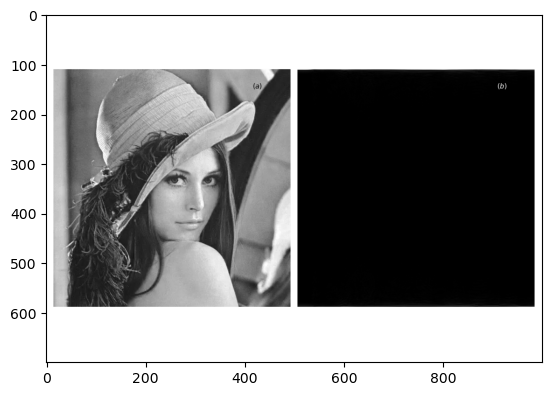

In [48]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('FFT2D.png')
plt.imshow(img)
plt.show()

4. Data packing/unpacking
  - 여러번 호출되는 Allgather 함수를 한 번의 호출로 변경
  - 데이터 재배열 필요

  <img src = "images/image23.png">

In [43]:
%%writefile FFT2D_2.py
import matplotlib.pyplot as plt
import numpy as np
from mpi4py import MPI
from tools import para_range

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

img = plt.imread('images/lenna.png')
imgr = img[:,:,0]

ly, lx = imgr.shape
kY, kX = np.ogrid[-ly/2:ly/2, -lx/2:lx/2]

sigh = 20
Fhgh = 1 - np.exp( -(kX**2 + kY**2) / (2*sigh**2))

jsta, jend = para_range(ly, size, rank)
H = np.fft.fft2(imgr[jsta:jend+1,:], axes = [1]).copy()
Hall = np.empty(imgr.shape, dtype = np.complex128)
comm.Allgather(H, Hall)

ista, iend = para_range(lx, size, rank)
H = np.fft.fft2(Hall[:,ista:iend+1], axes = [0]).copy()

chunk = int(lx/size)
Hall2 = np.empty((size * ly, chunk), dtype = np.complex128)

##### 계산 범위 취합 방식 수정
comm.Allgather(H, Hall2) # FIX ME

for i in range (ly) :
    for p in range (size) :
        # FIX ME
        Hall[i][p*chunk:p*chunk+chunk] = Hall2[i+p*ly][0:chunk]

Hs = np.fft.fftshift(Hall)
Ghgh = Hs.copy() * Fhgh
iGhgh = np.fft.ifftshift(Ghgh)

G = np.fft.ifft2(iGhgh[jsta:jend+1,:], axes = [1]).copy()
ghgh = np.empty(imgr.shape, dtype = np.complex128)
comm.Allgather(G, ghgh)

G = np.fft.ifft2(ghgh[:,ista:iend+1], axes = [0]).copy()

chunk = int(lx/size)
Gall = np.empty((size * ly, chunk), dtype = np.complex128)

##### 계산 범위 취합 방식 수정
comm.Allgather(G, Gall) #FIX ME

for i in range (ly) :
    for p in range (size) :
        # FIX ME
        ghgh[i][p*chunk:p*chunk+chunk] = Gall[i+p*ly][0:chunk]

if rank == 0 :
    fig = plt.figure(1, figsize = (10, 7))
    plt.subplot(121)
    plt.imshow(imgr, cmap = 'gray')
    plt.axis('off')
    plt.text(430,40,r'$(a)$', color = 'k')

    plt.subplot(122)
    plt.imshow(np.abs(ghgh), cmap = 'gray')
    plt.axis('off')
    plt.text(430,40,r'$(b)$', color = 'w')

    plt.tight_layout()
    plt.savefig('FFT2D_2.png')
    plt.show()


Overwriting FFT2D_2.py


In [44]:
!mpirun -np 2 python FFT2D_2.py

Figure(1000x700)


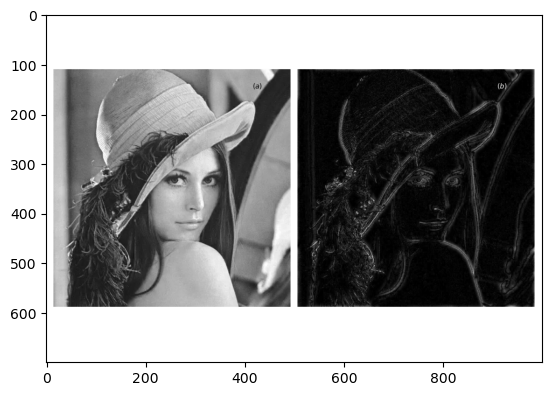

In [45]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('FFT2D_2.png')
plt.imshow(img)
plt.show()

5. Filter shape 변경
  - Inverse FFT 순서를 변경하면 분할된 상태에서 필터 적용 가능
  
  <img src = "images/image24.png">

Text(40, 40, '$(b)$ High-pass filter : shift')

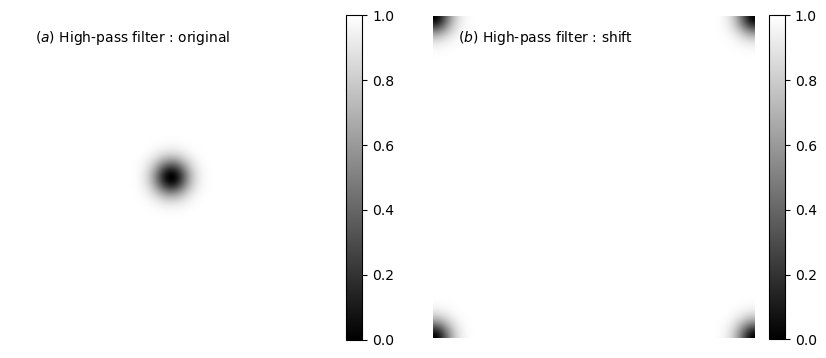

In [25]:
kY, kX = np.ogrid[-ly/2:ly/2, -lx/2:lx/2]

sigh = 20
Fhgh = 1 - np.exp( -(kX**2 + kY**2) / (2*sigh**2))

fig = plt.figure(2, figsize = (10, 7))
ax1 = plt.subplot(121)
pos = plt.imshow(Fhgh, cmap = 'gray')
plt.axis('off')
fig.colorbar(pos, ax=ax1, fraction=0.046, pad=0.04)
plt.text(40,40,r'$(a)$ High-pass filter : original', color = 'k')

kY, kX = np.ogrid[0:ly, 0:lx]
kX[0,256:512] = np.linspace(-256, -1, num = 256)
kY[256:512,0] = np.linspace(-256, -1, num = 256)

sigh = 20
Fhi2 = 1 - np.exp( -(kX**2 + kY**2) / (2*sigh**2))

ax2 = plt.subplot(122)
pos = plt.imshow(Fhi2, cmap = 'gray')
plt.axis('off')
fig.colorbar(pos, ax=ax2, fraction=0.046, pad=0.04)
plt.text(40,40,r'$(b)$ High-pass filter : shift', color = 'k')


In [35]:
%%writefile FFT2D_3.py
import matplotlib.pyplot as plt
import numpy as np
from mpi4py import MPI
from tools import para_range

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

img = plt.imread('images/lenna.png')
imgr = img[:,:,0]

ly, lx = imgr.shape

##### 필터 수정
kY, kX = np.ogrid[0:ly, 0:lx]
kX[0,256:512] = np.linspace(-256, -1, num = 256)
kY[256:512,0] = np.linspace(-256, -1, num = 256)

sigh = 20
Fhi2 = 1 - np.exp( -(kX**2 + kY**2) / (2*sigh**2))

jsta, jend = para_range(ly, size, rank)
H = np.fft.fft2(imgr[jsta:jend+1,:], axes = [1]).copy()
Hall = np.empty(imgr.shape, dtype = np.complex128)
comm.Allgather(H, Hall)

ista, iend = para_range(lx, size, rank)
H = np.fft.fft2(Hall[:,ista:iend+1], axes = [0]).copy()

##### Shift 불필요, 분할된 데이터에 해당 Filter영역 곱
iGhgh = H * Fhi2[:,ista:iend+1]#FIX ME

G = np.fft.ifft2(iGhgh, axes = [0]).copy()

chunk = int(lx/size)
Gall = np.empty((size * ly, chunk), dtype = np.complex128)

comm.Allgather(G, Gall)

ghgh = np.empty(imgr.shape, dtype = np.complex128)
for i in range (ly) :
    for p in range (size) :
        ghgh[i][p*chunk:p*chunk+chunk] = Gall[i+p*ly][0:chunk]

G = np.fft.ifft2(ghgh[jsta:jend+1,:], axes = [1]).copy()
comm.Allgather(G, ghgh)

if rank == 0 :

    fig = plt.figure(1, figsize = (10, 7))
    plt.subplot(121)
    plt.imshow(imgr, cmap = 'gray')
    plt.axis('off')
    plt.text(430,40,r'$(a)$', color = 'k')

    plt.subplot(122)
    plt.imshow(np.abs(ghgh), cmap = 'gray')
    plt.axis('off')
    plt.text(430,40,r'$(b)$', color = 'w')

    plt.tight_layout()
    plt.savefig('FFT2D_3.png')
    plt.show()


Overwriting FFT2D_3.py


In [36]:
!mpirun -np 2 python FFT2D_3.py

Figure(1000x700)


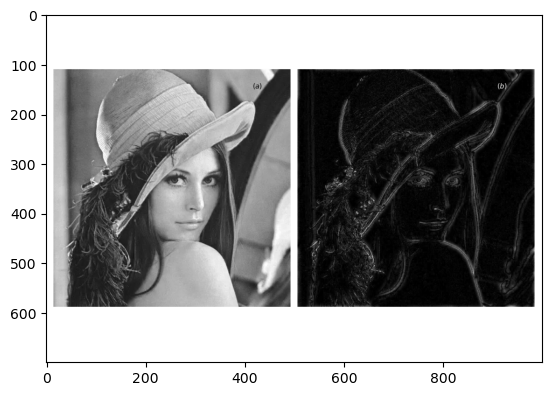

In [42]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('FFT2D_3.png')
plt.imshow(img)
plt.show()